In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.datasets import fetch_species_distributions
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from math import radians, sin, cos, sqrt, atan2
from scipy.spatial import cKDTree

In [61]:
presences = pd.read_excel("../../Data/Data_train/Presences_Absences_train.xlsx") #fichier csv presences/absences
po = pd.read_csv('C:/Users/Admin/Desktop/Presences_only_train.csv', sep=';')
po = po[['speciesId','lat', 'lon']]

In [44]:
blind = pd.read_csv("../../Data/Data_submission/test_blind.csv", sep=";") #fichier csv qui sera merge pas les prédiction et soumis sur Kaggle

In [90]:
presences_patchID = presences.groupby(['lat', 'lon'])['speciesId'].apply(set).reset_index()

In [5]:
po1 = po[0:50]

In [15]:
presences_patchID.loc[5]["lat"]

41.70986

In [86]:
import pandas as pd
from math import radians, sin, cos, sqrt, atan2

# Function to calculate the Haversine distance between two coordinates
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance

# Function to find the nearest speciesId
def find_nearest_species(lat, lon):
    distances = po.apply(lambda row: haversine(lat, lon, row['lat'], row['lon']), axis=1)
    nearest_species_index = distances.idxmin()
    nearest_species_id = po.loc[nearest_species_index, 'speciesId']
    return nearest_species_id


In [127]:
# Create a KDTree from df1 coordinates
tree = cKDTree(list(zip(po['lat'], po['lon'])))

# Function to find the nearest speciesId using KDTree
def find_nearest_species(lat, lon):
    _, idx = tree.query((lat, lon), k = 2)
    nearest_species_ids = po.loc[idx, 'speciesId'].tolist()
    return nearest_species_ids

# Use vectorized operations to apply the function to df2
#for i in range(len(presences_patchID)):
 #   nearest_species = find_nearest_species(presences_patchID.loc[i]["lat"], presences_patchID.loc[i]["lon"])
  #  for j in range(len(nearest_species)):
   #     presences_patchID.loc[i]["speciesId"].add(nearest_species[j])
    #print(i)
# Drop duplicates in df2 to keep each speciesId only once
#presences_patchID = presences_patchID.drop_duplicates(subset='nearest_speciesId')

In [101]:
def k_voisins_proba(k,proba, data, test):
    """
    données:
        k: nombre de voisins considérés 
        data: dataFrame contenant entre autre les patch_ID et les espèces associées du train-PA
        test: dataFrame provenant du CSV Kaggle contenant les informations sur les lieux où la prédiction
        doit être faite
    fonction: 
        Liste les espèces présentes dans les k-voisins les plus proches de chaque coordonnées du dataFrame
        test à partir des information de data. 
    résultat:
        resultat: Un fichier CSV contenant les prédicitions d'especes dans la colonne Predicted 
    """
    # data frame contenant les espèces_id selon la lat,lon où l'espèce est recensées (sans doublons)
    data_sans_doublons = presences_patchID.reset_index()

     # Données utilisées par l'algo 
    X1 = blind[['lat', 'lon']].values
    X2 = data_sans_doublons[['lat', 'lon']].values

        # Création du modèle
    nn = NearestNeighbors(n_neighbors= k)
    nn.fit(X2)
    # le modèle retourne l'indice des k-voisins ainsi que leurs distances du point
    distances, indices = nn.kneighbors(X1)

    result = []
    for i in range(len(test)):
        nearest_species = {}
        for j in range(len(indices[i])):
            index = indices[i][j]
            species_list = data_sans_doublons.loc[index]['speciesId']
            for species in species_list:
                if species in nearest_species:
                    nearest_species[species] += 1
                else:
                    nearest_species[species] = 1
        selected_species = [species for species, count in nearest_species.items() if count > proba * k]
        result.append(list(selected_species))

    # Traitement pour l'export du CSV au format acceptable par Kaggle
    test['nearest_species'] = result
    # test = test[['Id', 'nearest_species']]
    #test = test.rename(columns={'nearest_species': 'Predicted'})    
    #test['Predicted'] = test['Predicted'].apply(lambda x: str(x).replace('[', '').replace(']', '').replace(',', ''))
    #test.to_csv('80-voisins-proba-018-2-po.csv', index=False, sep=',')

    return test 

In [128]:
%%time
result = k_voisins_proba(80,0.20, presences_patchID, blind)

Wall time: 4min 9s


In [130]:
result = result[['Id', 'nearest_species']]
result = result.rename(columns={'nearest_species': 'Predicted'})    
result['Predicted'] = result['Predicted'].apply(lambda x: str(x).replace('[', '').replace(']', '').replace(',', ''))
result.to_csv('80-voisins-proba-02-2-po.csv', index=False, sep=',')

In [118]:
result

,Id,datasetName,date,dayOfYear,year,patchID,timeSerieID,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,nearest_species
0,1,CBNMed,1629064800,228,2021,10125,3988380,1.729607,42.52171,3.640762e+06,2.194746e+06,5.0,"[386, 5263, 6574, 2098, 6837, 4284, 5314, 5989..."
1,2,CBNMed,1629064800,228,2021,10126,3997090,1.729624,42.52177,3.640764e+06,2.194753e+06,4.0,"[386, 5263, 6574, 2098, 6837, 4284, 5314, 5989..."
2,3,CBNMed,1629064800,228,2021,10127,4001106,1.729652,42.52197,3.640769e+06,2.194775e+06,5.0,"[386, 5263, 6574, 2098, 6837, 4284, 5314, 5989..."
3,4,CBNMed,1629064800,228,2021,10129,4004605,1.729671,42.52192,3.640770e+06,2.194769e+06,6.0,"[386, 5263, 6574, 2098, 6837, 4284, 5314, 5989..."
4,5,CBNMed,1531346400,193,2018,10154,3987660,1.826847,42.57452,3.649316e+06,2.199695e+06,0.0,"[386, 5263, 6574, 2098, 6837, 4284, 5314, 5989..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22399,22400,Inventaire forestier IGN,2018-03-14,73,2018,3018864,3990152,9.421020,42.38755,4.273164e+06,2.142680e+06,1.0,"[265, 268, 271, 5815, 2749, 5959, 6361, 7648, ..."
22400,22401,Inventaire forestier IGN,2018-03-22,81,2018,3018865,3986840,9.429860,42.26077,4.273796e+06,2.128639e+06,1.0,"[265, 268, 3097, 2854, 2871, 5815, 2749, 5959,..."
22401,22402,Inventaire forestier IGN,2017-03-13,72,2017,3018866,3993669,9.462680,42.92578,4.277004e+06,2.202255e+06,1.0,"[265, 2871, 5815, 2749, 6353, 3833, 5959, 6361..."
22402,22403,Inventaire forestier IGN,2017-03-15,74,2017,3018867,3993567,9.497790,42.41844,4.279528e+06,2.146054e+06,1.0,"[265, 268, 271, 5815, 2749, 5959, 6361, 7648, ..."


In [129]:
for i in range(len(result)):
    nearest_species = find_nearest_species(result.loc[i]["lat"], result.loc[i]["lon"])
    for j in range(len(nearest_species)):
        if nearest_species[j] not in result.at[i, 'nearest_species']:
            result.at[i, 'nearest_species'].append(nearest_species[j])

In [74]:
tree

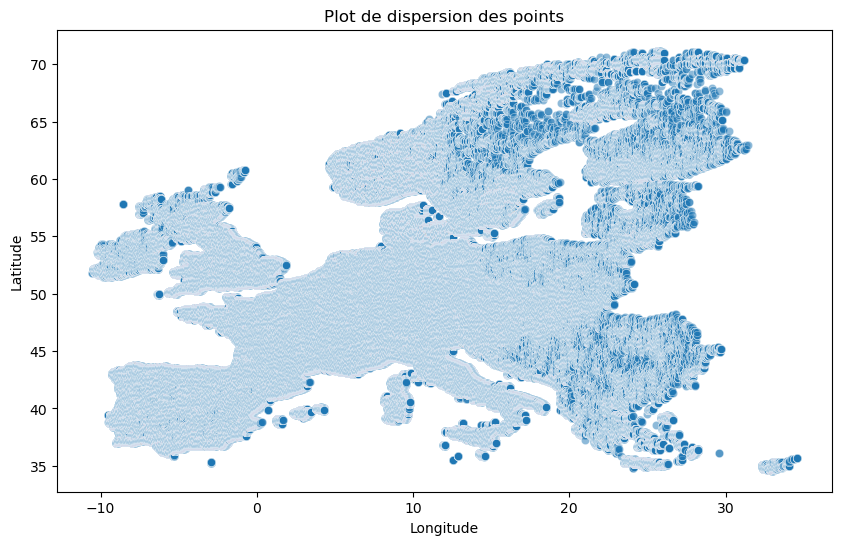

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='lon', y='lat', data=data, alpha=0.5)
plt.title('Plot de dispersion des points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [143]:
data_sans_doublons = presences.groupby(['lat', 'lon'])['patchID'].first().reset_index()
data_sans_doublons

,lat,lon,patchID
0,41.566910,9.298340,3018847
1,41.641550,9.259160,3018834
2,41.664130,9.189780,3018819
3,41.665690,9.165940,3018812
4,41.670930,9.358710,3018853
...,...,...,...
4598,58.580451,-4.037544,3001028
4599,58.581780,-4.044330,3001017
4600,58.581813,-4.044289,3001018
4601,58.582080,-4.042799,3001019


In [152]:
# data frame contenant les espèces_id selon la lat,lon où l'espèce est recensées (sans doublons)
data_sans_doublons = presences.groupby(['lat', 'lon'])['speciesId'].first().reset_index()

# Données utilisées par l'algo 
X1 = blind[['lat', 'lon']].values
X2 = data_sans_doublons[['lat', 'lon']].values

# Création du modèle
nn = NearestNeighbors(n_neighbors= 80)
nn.fit(X2)
# le modèle retourne l'indice des k-voisins ainsi que leurs distances du point
distances, indices = nn.kneighbors(X1)

array([  40,   42,   54,   53,   52,   56,   57,   63,   51,   79,   84,
         50,   78,   95,   47,   77,   62,   83,   76,   69,   91,  101,
         90,   44,   75,   94,   89,   68,   49,   93,   46,   55,   82,
         74,   73,   67,   88,   61,   87,   45,   60,   48,   66,   86,
         81,   85,   59,   72,   65, 1171,   80, 1147,   71,   58,   70,
       1221,   64, 1199, 1254, 1258, 1242, 1259,   43, 1257,   41, 1230,
       1262, 1282, 1283, 1276, 1284, 1302, 1239, 1295, 1328, 1301, 1256,
       1340, 1300, 1358], dtype=int64)

In [185]:
points = []
lat_lon_values = data_sans_doublons.iloc[indices[3000]][['lat', 'lon']].values
points.append(lat_lon_values)
points

[array([[43.36739 ,  6.08494 ],
        [43.15854 ,  6.074606],
        [43.15844 ,  6.074548],
        [43.15373 ,  6.080298],
        [43.14524 ,  6.085294],
        [43.14382 ,  6.084886],
        [43.32976 ,  6.13177 ],
        [43.14651 ,  6.09645 ],
        [43.14649 ,  6.096442],
        [43.13568 ,  6.095677],
        [43.14978 ,  6.107394],
        [43.13523 ,  6.095923],
        [43.13514 ,  6.096004],
        [43.13554 ,  6.096763],
        [43.13475 ,  6.09618 ],
        [43.13465 ,  6.096113],
        [43.13478 ,  6.096476],
        [43.13485 ,  6.096665],
        [43.13489 ,  6.096753],
        [43.13583 ,  6.097774],
        [43.14814 ,  6.107941],
        [43.14811 ,  6.107932],
        [43.13704 ,  6.102227],
        [43.13716 ,  6.102406],
        [43.15027 ,  6.11993 ],
        [43.31094 ,  6.15516 ],
        [43.14899 ,  6.12043 ],
        [43.1045  ,  6.0797  ],
        [43.14912 ,  6.1206  ],
        [43.20324 ,  6.14801 ],
        [43.15212 ,  6.127273],
        

In [197]:
type(points)

list

In [194]:
import folium

# Supposons que vous avez déjà les résultats et les données de test
# Assurez-vous que les indices correspondent entre result et test_df

# Initialisation des variables pour la carte
m = folium.Map(location=[47,1], zoom_start=10)

for i in range(len(points[0])):
    color = 'green'  # Prédiction correcte ou jusqu'à 4 erreurs (vert)
    # Ajout du marqueur sur la carte
    folium.Marker(
        location=[points[0][i][0] , points[0][i][1]],
        icon=folium.Icon(color=color)
    ).add_to(m)

folium.Marker(
        location=[blind.iloc[3000]['lat'] , blind.iloc[3000]['lon'] ],
        icon=folium.Icon(color='red')
    ).add_to(m)
# Sauvegarde de la carte dans un fichier HTML
m.save('carte_leaflet1.html')